In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# We are working on this project in google colab, hence the pip install
!pip install -Uqq ipdb

     |████████████████████████████████| 761 kB 5.4 MB/s 
     |████████████████████████████████| 386 kB 62.2 MB/s 
     |████████████████████████████████| 1.6 MB 52.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.7.0 which is incompatible.


In [5]:
# Import the related libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import ipdb
import torch.nn as nn
import torch.optim as optim

In [6]:
# Import the training data
csv_pds = []
dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31"):
    if file.endswith(".csv"):
        csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31/"+file,on_bad_lines="skip"))
        dates.append(file[0:8])

In [7]:
# Preprocessing of our data
# Since the covid data we obtain from the HK gov website has some minor typo in their district names,
# we use a sequence matcher to match the closest name to the district defined in the districts array
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter)
  iter +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [8]:
series_count_district = {}
for district in districts:
    series_count_district[district] = []

In [9]:
day =0
for pd in csv_pds:
    for district in districts:
          series_count_district[district].append((pd['District'] == district).sum())

In [10]:
district_series = []
for district in districts:
  district_series.append(series_count_district[district])

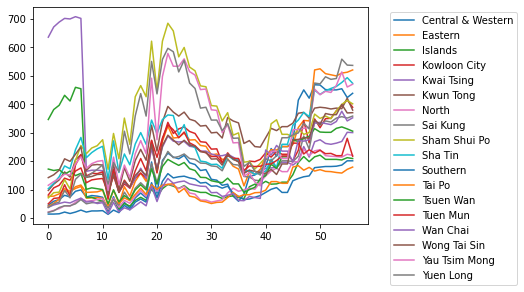

In [11]:
# Plot the series_count_district data to have an overview 
for district in series_count_district:
    plt.plot(series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Basic LSTM Model 

In [12]:
# Our Basic LSTM model
# N = 100 # number of theoretical series of games
# L = 1000 # number of games in each series
# T = 20

class LSTMPredictor(nn.Module):
  def __init__(self, n_hidden = 51):
    super(LSTMPredictor, self).__init__()
    self.n_hidden = n_hidden
    # Layers used: lstm1, lstm2 (for making model learn), linear (prediction)
    # input feature size is 1, since we pass in covid data daily, one by one
    self.lstm1 = nn.LSTMCell(1, self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden, 1)
    # output feature size is 1, since predict the next day value

  # future = 0 -> don't predict future values, just predict output that we know
  def forward(self, x, future = 0):
    outputs = []
    n_samples = x.size(0)

    h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    # N, 100
    for input_t in x.split(1, dim=1):
      # N, 1
      h_t, c_t = self.lstm1(input_t, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    # if future > 0
    for i in range(future):
      h_t, c_t = self.lstm1(output, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    
    return outputs

In [13]:
y = np.array(district_series).astype(np.float32)  # (18, 57)
# target shifted one value (day) into the future
train_input = torch.from_numpy(y[:, :-1])         # (18, 56)
train_target = torch.from_numpy(y[:, 1:])         # (18, 56)
test_input = torch.from_numpy(y[:1, :-1])         # (3, 56)
test_target = torch.from_numpy(y[:1, :])          # (3, 57)

# Initiating our basic lstm model
model = LSTMPredictor()
criterion = nn.MSELoss() 
optimizer = optim.LBFGS(model.parameters(), lr =0.01)
n_steps = 150 #EPOCH

# Training our model
for i in range(n_steps):
  # closure for the optimizer
  def closure():
    # empty gradients, apply forward then backward step, then apply criterion
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out, train_target)
    loss.backward()
    return loss
  optimizer.step(closure)

test loss 14135.8134765625
test loss 12647.3330078125
test loss 8417.3408203125
test loss 8386.1044921875
test loss 4893.154296875
test loss 7874.30419921875
test loss 15049.5693359375
test loss 12575.8642578125
test loss 13586.966796875
test loss 8316.7744140625
test loss 16992.896484375
test loss 14488.8212890625
test loss 8430.07421875
test loss 8532.50390625
test loss 15116.529296875
test loss 6744.44140625
test loss 11926.3056640625
test loss 15170.873046875


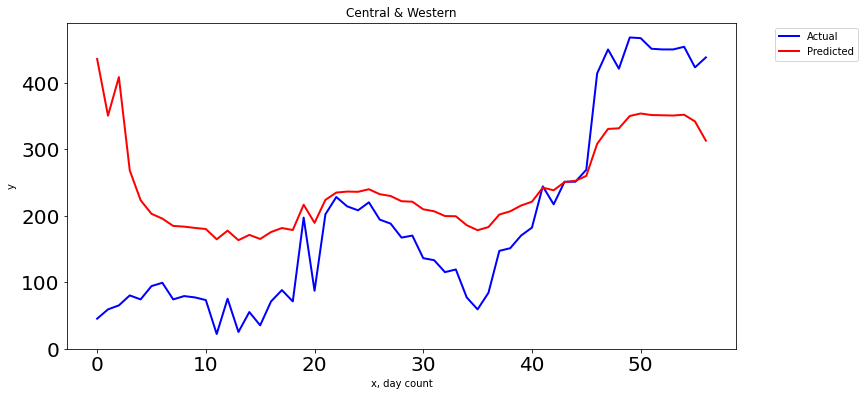

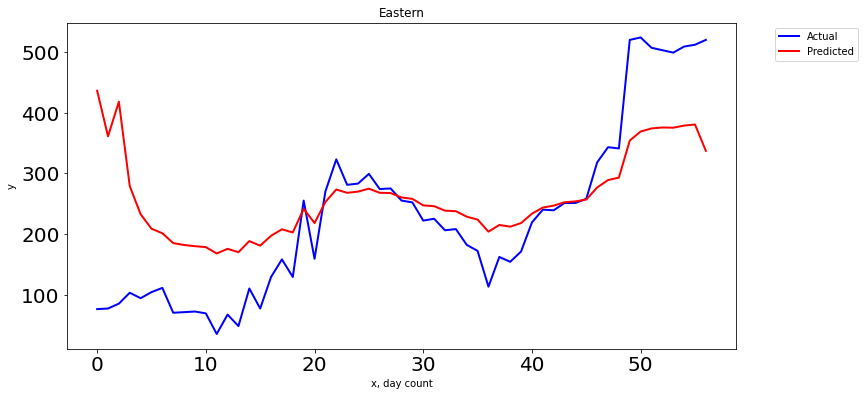

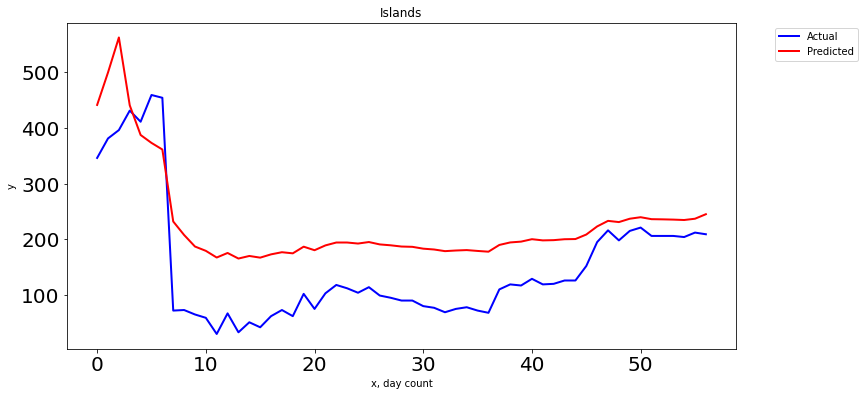

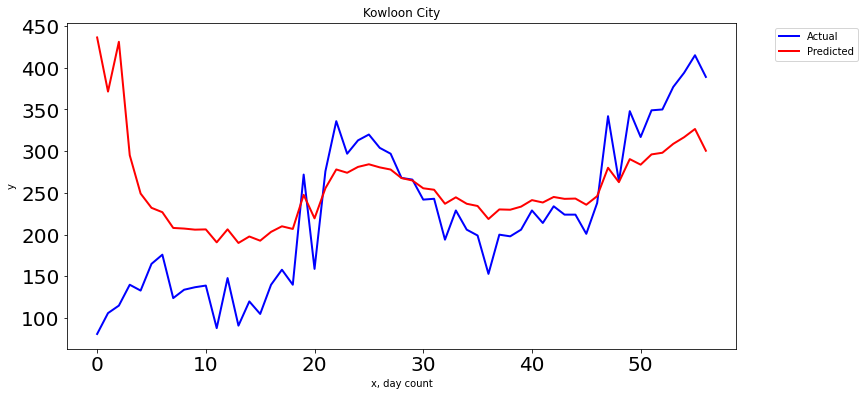

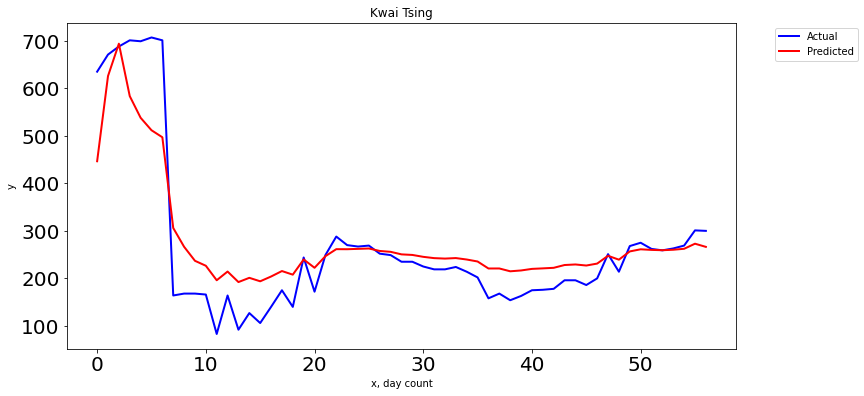

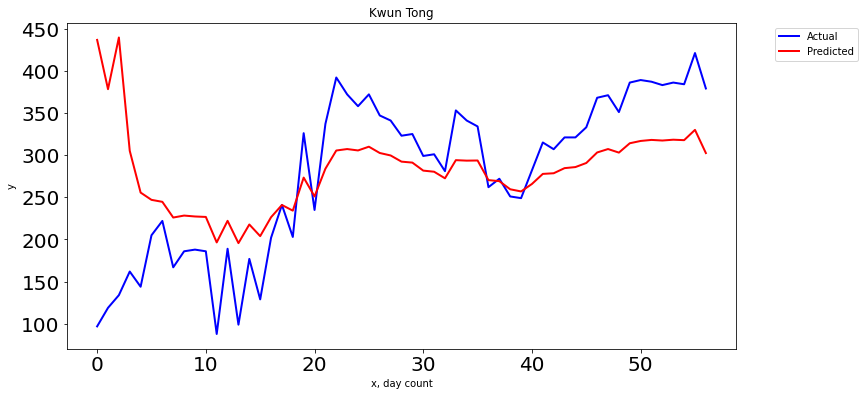

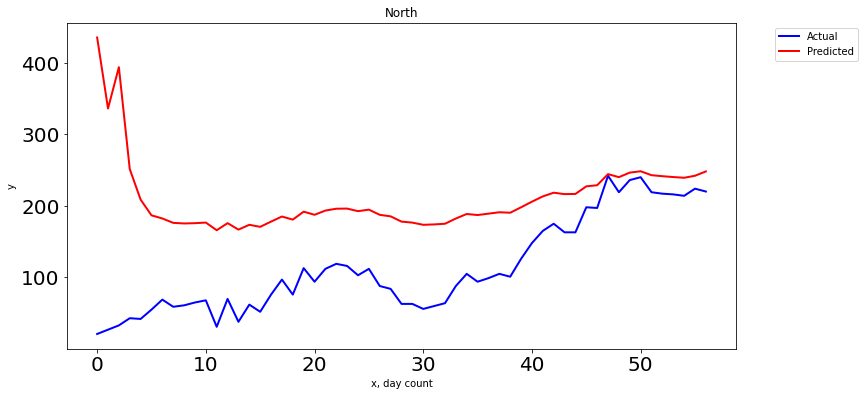

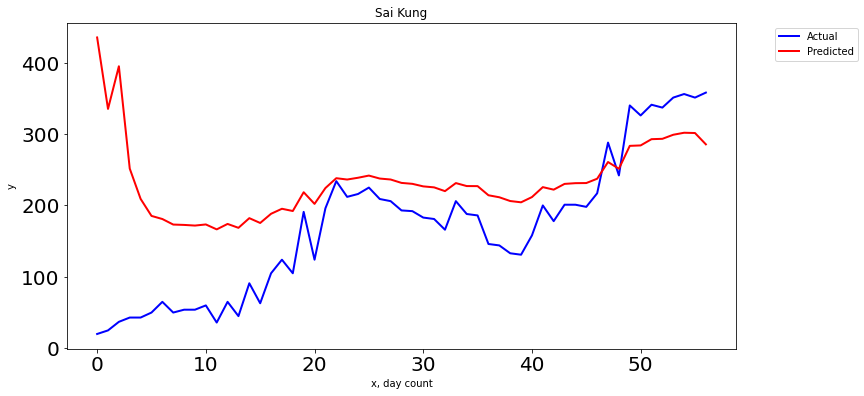

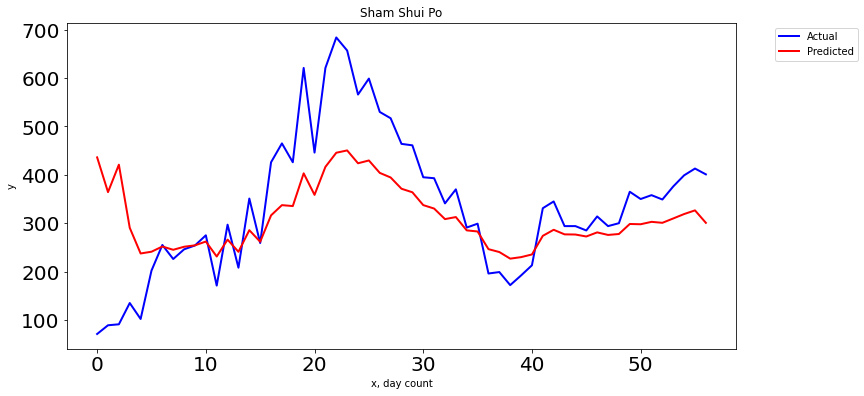

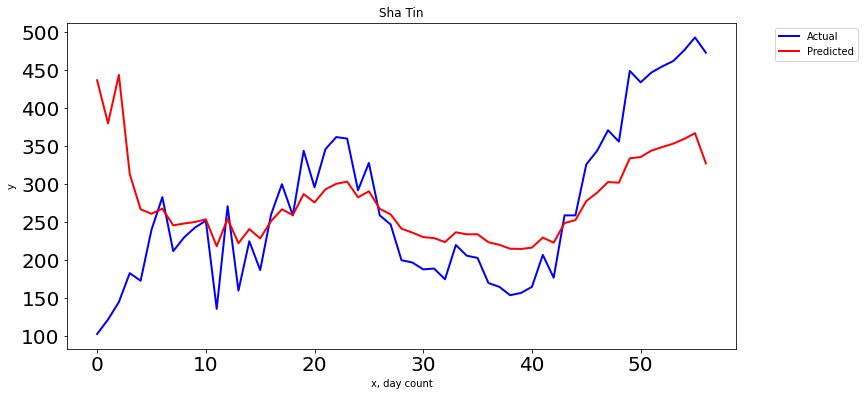

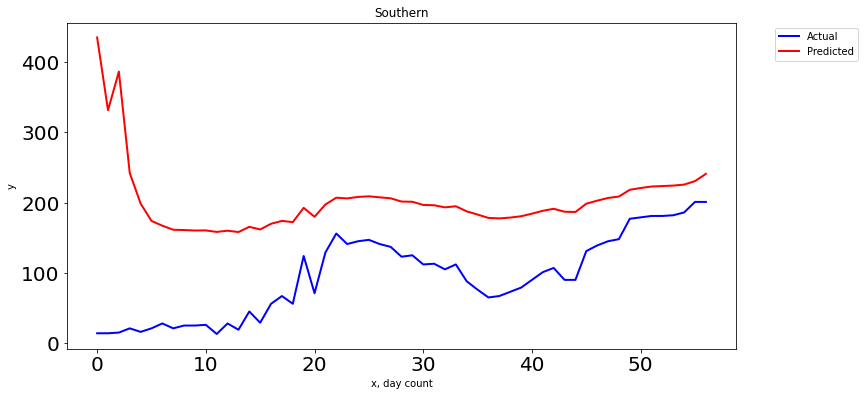

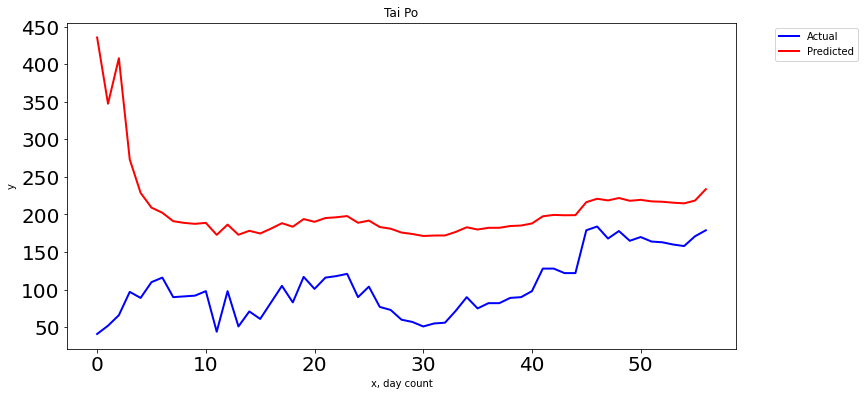

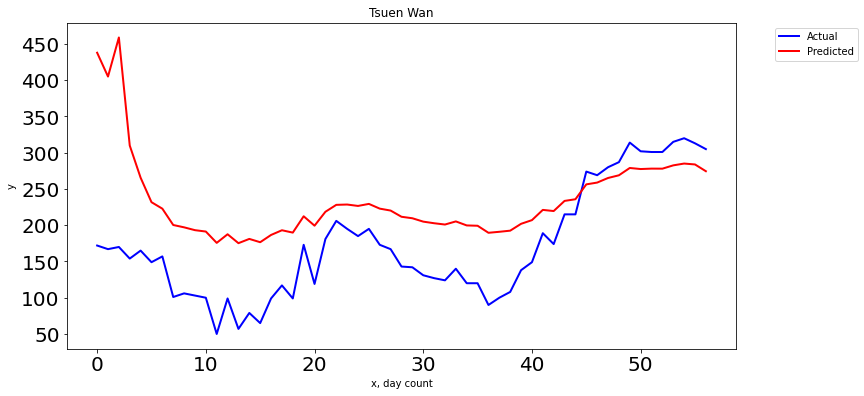

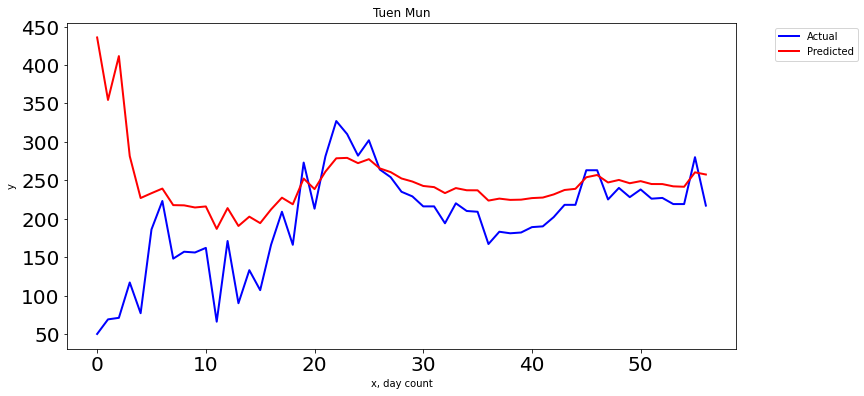

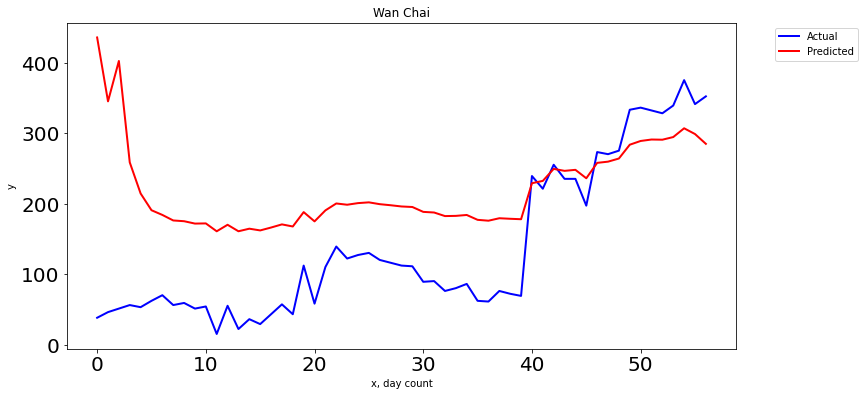

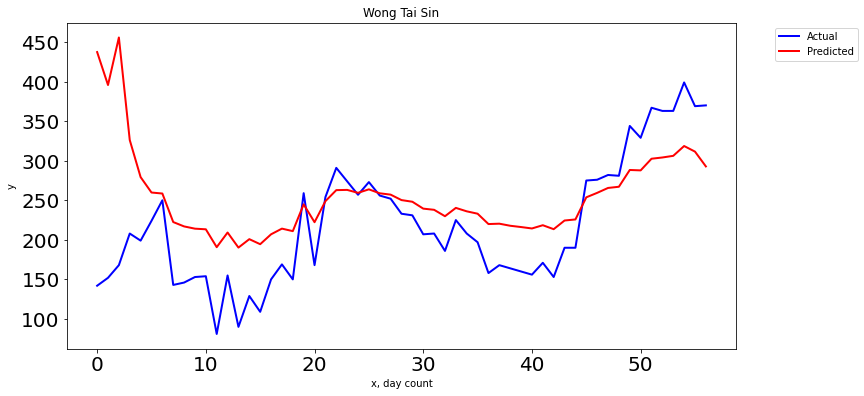

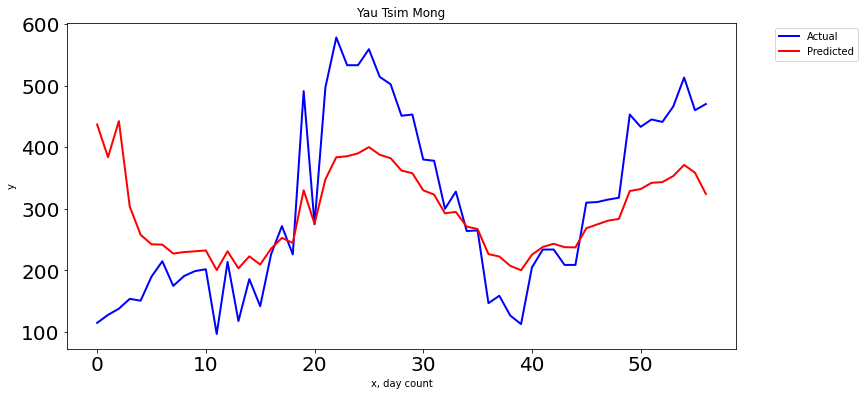

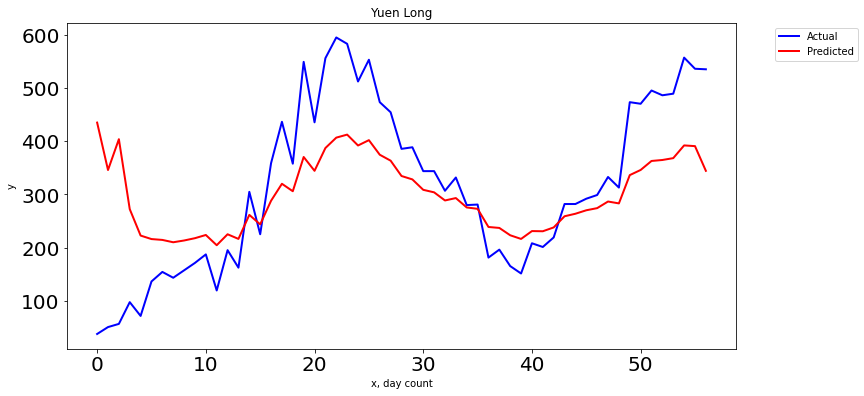

In [14]:
# Validate the accuracy of basic lstm model using Symmetric mean absolute percentage error (SMAPE)
# More details on https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
# Plot the graph of our prediction against the test_target
pred_districts = []
predictions = []
value = np.array(district_series).astype(np.float32)

for j in range(len(districts)):
  test_input = torch.from_numpy(value[j:j+1, :-1]) # 3, 56
  test_target = torch.from_numpy(value[j:j+1, :]) # 3, 57  
  with torch.no_grad():
    future = 1 
    pred = model(test_input, future=future)
    loss = criterion(pred, test_target)
    print("test loss", loss.item()) 
    y = pred.detach().numpy()
  
  plt.figure(figsize=(12,6))
  plt.title(districts[j])
  plt.xlabel("x, day count")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = test_target.shape[1]
  def draw(y_i, color):
    plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0,label = "Actual") # actual values
    plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0, label = "Predicted") # predicted values
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  draw(y[0], 'r')

  #SMAPE Equation
  pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [15]:
pred_districts = np.array(pred_districts)
print(pred_districts)

[1.70123206 1.2667568  1.7880338  0.89083756 0.62835614 0.74673494
 2.12672806 1.54908763 0.82935015 0.72857587 2.57174534 2.14273114
 1.27653408 0.85196453 2.19013384 0.81592883 0.8966713  1.03220134]


LSTM with Pearson Correlation 

Create 18 different models for each district based on its adjacency matrix


In [16]:
# # Creating the pearson correlation matrix
# correlation = np.corrcoef(district_series, district_series)
# useful_correlation = correlation[0:18,0:18]

# connection_threshold = 0.7 
# adjacency_matrix = np.where(useful_correlation > connection_threshold, 1, 0)

In [17]:
# # Our LSTM model with pearson correlation
# # N = 100 # number of theoretical series of games
# # L = 1000 # number of games in each series
# # T = 20

# class LSTMPredictor(nn.Module):
#   def __init__(self, n_hidden = 51):
#     super(LSTMPredictor, self).__init__()
#     self.n_hidden = n_hidden
#     # Layers used: lstm1, lstm2 (for making model learn), linear (prediction)
#     # input feature size is 1, since we pass in covid data daily, one by one
#     self.lstm1 = nn.LSTMCell(1, self.n_hidden)
#     self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
#     self.linear = nn.Linear(self.n_hidden, 1)
#     # output feature size is 1, since predict the next day value

#   # future = 0 -> don't predict future values, just predict output that we know
#   def forward(self, x, future = 0):
#     outputs = []
#     n_samples = x.size(0)

#     h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
#     c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
#     h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
#     c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

#     # N, 100
#     for input_t in x.split(1, dim=1):
#       # N, 1
#       h_t, c_t = self.lstm1(input_t, (h_t, c_t))
#       h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#       output = self.linear(h_t2)
#       outputs.append(output)
    
#     # if future > 0
#     for i in range(future):
#       h_t, c_t = self.lstm1(output, (h_t, c_t))
#       h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#       output = self.linear(h_t2)
#       outputs.append(output)
    
#     outputs = torch.cat(outputs, dim=1)    
#     return outputs

In [18]:
# y = np.array(district_series).astype(np.float32)  # (18, 57)
# # target shifted one value (day) into the future
# train_input = torch.from_numpy(y[:, :-1])         # (18, 56)
# train_target = torch.from_numpy(y[:, 1:])         # (18, 56)
# test_input = torch.from_numpy(y[:1, :-1])         # (3, 56)
# test_target = torch.from_numpy(y[:1, :])          # (3, 57)

# # EPOCH
# n_steps = 150

# # Use adjacency_matrix such take the model take counts of those districts that are highly corelated (threshold = 0.7)
# np_train_input = np.array([np.array([y[j:j+1,:-1] for j in range(18) if adjacency_matrix[i][j] == 1]) for i in range(18)])
# np_train_target = np.array([np.array([y[j:j+1,1:] for j in range(18) if adjacency_matrix[i][j] == 1]) for i in range(18)])
# models = []

# for j in range(18):
#   train_input = torch.from_numpy(np_train_input[j].reshape(-1,56))
#   train_target = torch.from_numpy(np_train_target[j].reshape(-1,56))
#   model = LSTMPredictor()
#   criterion = nn.MSELoss()
#   optimizer = optim.LBFGS(model.parameters(), lr =0.01)
#   for i in range(n_steps):
#     # closure for the optimizer
#     def closure():
#       # empty gradients, apply forward then backward step, then apply criterion
#       optimizer.zero_grad()
#       out = model(train_input)
#       loss = criterion(out, train_target)
#       loss.backward()
#       return loss

#     optimizer.step(closure)
#   models.append(model)

In [19]:
# # Save the created models
# for i in range(len(models)):
#   torch.save(models[i].state_dict(), f"/content/drive/MyDrive/COMP 4222/lstm_covid/{districts[i]}_model")

In [20]:
# Load the saved models
districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

models = [LSTMPredictor()] * 18
for i in range(18):
  models[i].load_state_dict(torch.load(f"/content/drive/MyDrive/COMP 4222/lstm_covid/{districts[i]}_model"))

In [21]:
# pred_districts = []
# predictions = []
# value = np.array(district_series).astype(np.float32)

# for j in range(len(districts)):
#   model = models[j]
#   test_input = torch.from_numpy(value[j:j+1, :-1]) # 3, 56
#   test_target = torch.from_numpy(value[j:j+1, :]) # 3, 57  
#   with torch.no_grad():
#     future = 1 
#     pred = model(test_input, future=future)
#     loss = criterion(pred, test_target)
#     print("test loss", loss.item())
#     y = pred.detach().numpy()
  
#   plt.figure(figsize=(12,6))
#   plt.title(districts[j])
#   plt.xlabel("x, day count")
#   plt.ylabel("y")
#   plt.xticks(fontsize=20)
#   plt.yticks(fontsize=20)
#   n = test_target.shape[1]
#   def draw(y_i, color):
#     plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0,label = "Actual") # actual values
#     plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0, label = "Predicted") # predicted values
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#   draw(y[0], 'r')

#   #SMAPE Equation
#   pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [22]:
# pred_districts = np.array(pred_districts)
# print(pred_districts)

test Apr1 to may31

In [ ]:
import pandas as pd
test_csv_pds = []
test_dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Sep1_Oct31"):
    if file.endswith(".csv"):
        test_csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Sep1_Oct31/"+file,on_bad_lines="skip"))
        test_dates.append(file[0:8])



from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in test_csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter)
  iter +=1

0


In [ ]:
test_series_count_district ={}
for district in districts:
    test_series_count_district[district] = []

day =0
for pd in test_csv_pds:
    for district in districts:
          test_series_count_district[district].append((pd['District'] == district).sum())

In [ ]:
#plot the series_count_district data
for district in test_series_count_district:
    # if(district == "Wong Tai Sin"):
    plt.plot(test_series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
test_district_series = []
for district in districts:
  test_district_series.append(test_series_count_district[district])

In [ ]:
test_pred_districts = []
value = np.array(test_district_series).astype(np.float32)
criterion = nn.MSELoss() 

for j in range(18):
  model = models[j]
  test_input = torch.from_numpy(value[j:j+1, :-1]) # (3, 56)
  test_target = torch.from_numpy(value[j:j+1, :])  # (3, 57) 
  with torch.no_grad():
    future = 1 
    pred = model(test_input, future=future)
    loss = criterion(pred, test_target)
    print("test loss", loss.item())
    y = pred.detach().numpy()
  
  plt.figure(figsize=(12,6))
  plt.title(districts[j])
  plt.xlabel("x, day count")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = test_target.shape[1]
  def draw(y_i, color):
    plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0,label = "Actual") # actual values
    plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0, label = "Predicted") # predicted values
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  draw(y[0], 'r')

  #SMAPE Equation
  test_pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [ ]:
print(np.array(test_pred_districts).mean()) # predictions (error rate)
print(np.array(test_pred_districts).std()) # predictions (error rate)